In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import math
import matplotlib.pyplot as plt
import init_objects
from functions.helpers import organise_data, hypothetical_series, get_specific_bootstraps_moments, confidence_interval
from functions.inequality import gini
from model import *
import statsmodels.api as sm
from matplotlib import style
from functions.evolutionaryalgo import *
import scipy.stats as stats
from SALib.sample import latin
import statsmodels.api as sm
import scipy.stats
from statsmodels.iolib.summary2 import summary_col
import quandl

In [2]:
style.use('seaborn-ticks')

# Stock market volatility and wealth inequality

1. calibration
2. model dynamics 
3. experiment --> regression 
4. robustness check

## 1 Calibration
First, I collect data from Shiller on price volatility

In [4]:
shiller_data = pd.read_excel('http://www.econ.yale.edu/~shiller/data/ie_data.xls', sheet_name='Data', header=7)[:-3]
p = pd.Series(np.array(shiller_data.iloc[1174:-1]['Price'])) #starting in 1952  was 1224
p_returns = pd.Series(np.array(shiller_data.iloc[1174:]['Price'])).pct_change()[1:]

In [22]:
params = {
    "ticks": len(p),  
    "n_traders": 20, # selected for comp efficiency
    "init_stocks": int((21780000000 / 267.33) / float(1000000)), # market valuation of Vanguard S&P 500 / share price  
    "init_price": p.mean(), # average value of reference data
    "white_noise": 0.05,
         }

In [23]:
params

{'ticks': 614,
 'n_traders': 20,
 'init_stocks': 81,
 'init_price': 1147.8213214905302,
 'white_noise': 0.05}

Next, I estimate the uncertain parameters using the Method of Simulated moments.There are two moments that I aim to match. These are (1) the standard deviation of returns (because this is the variable of primary interest) and (2) the autocorrelation of returns, which should be close to zero to indicate that prices are not predictable. 

In [9]:
emp_moments = np.array([
    p_returns.std(),
    autocorrelation_returns(p_returns, 25),
    ])
emp_moments

array([0.03600149, 0.00970407])

To account for the fact that some of these moments might correlate over different Monte Carlo Simulations, the MSM seeks to obtain a variance covariance matrix of the moments. Since there is only one empirical reality, I use a bootstrap procedure to create a covariance matrix of empirical moments. For this, I use a block bootstrap procedure.

In [10]:
BLOCK_SIZE = 25
BOOTSTRAPS = 100

In [11]:
p_data_blocks = []
for x in range(0, len(p_returns[:-3]), BLOCK_SIZE):
    p_data_blocks.append(p_returns[x:x + BLOCK_SIZE])

In [12]:
bootstrapped_p_returns = []
for i in range(BOOTSTRAPS):
    sim_data_p = [random.choice(p_data_blocks) for _ in p_data_blocks]
    sim_data2_p = [j for i in sim_data_p for j in i]
    bootstrapped_p_returns.append(sim_data2_p)

In [13]:
rets_std = []
rets_autocor = []

for rets in bootstrapped_p_returns:
    rets_std.append(pd.Series(rets).std())
    rets_autocor.append(autocorrelation_returns(rets, 25))

In [14]:
all_bootstrapped_moments = [
                            rets_std,
                            rets_autocor
                           ]

In [15]:
av_moments = [np.nanmean(x) for x in all_bootstrapped_moments]
moments_b = [get_specific_bootstraps_moments(all_bootstrapped_moments, n) for n in range(len(bootstrapped_p_returns))]

Here, I follow [Franke & Westerhoff 2016](https://link.springer.com/article/10.1007/s11403-014-0140-6#Sec8) in that I use the inverse of the bootstrap estimate of the moment covariance matrix as my weights.

In [16]:
W_hat = 1.0 / len(bootstrapped_p_returns) * sum([np.dot(np.array([(mb - av_moments)]).transpose(), np.array([(mb - av_moments)])) for mb in moments_b])
W = np.linalg.inv(W_hat)
np.save('distr_weighting_matrix', W)

I establish confidence intervals for the moments.

In [18]:
confidence_intervals = [confidence_interval(m, emp) for m, emp in zip(all_bootstrapped_moments, emp_moments)]

To start the estimation procedure, I first sample the parameter space using Latin Hypercube sampling

In [19]:
population_size = 1

In [20]:
problem = {
  'num_vars': 1,
  'names': ['white_noise'],
  'bounds': [[0.01, 0.10]]
}

In [21]:
latin_hyper_cube = latin.sample(problem=problem, N=population_size)
latin_hyper_cube = latin_hyper_cube.tolist()
with open('hypercube.txt', 'w') as f:
    json.dump(latin_hyper_cube, f)
initial_params = latin_hyper_cube[0]
initial_params

[0.029533287689849995]

I perform the estimation excercise in a different Python file using multi-processing. I download the resulting paramters below.

In [24]:
with open('estimated_params.json', 'r') as f:
    est_params = json.loads(f.read())

In [25]:
for i, name in enumerate(problem['names']):
    params[name] = est_params[i]

In [26]:
params

{'ticks': 614,
 'n_traders': 20,
 'init_stocks': 81,
 'init_price': 1147.8213214905302,
 'white_noise': 0.09868507507793324}

## 2 Baseline simulations

In [30]:
NRUNS = 10

In [31]:
trdrs = []
orbs = []
for seed in range(NRUNS):
    traders, orderbook = init_objects.init_objects_model(params, seed)
    traders, orderbook = volatility_inequality_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9


### 2.1 Dynamics 

#### 2.1.1 Price, returns & volume 
First, I observe the baseilne dynamics of the price and volume of the risky asset. 

In [66]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume = organise_data(orbs, burn_in_period=2)

In [79]:
lower_autocorr = []
upper_autocorr = []
for row in range(len(mc_autocorr_returns)):
    autocor_range = mc_autocorr_returns.iloc[row]
    lower, upper = confidence_interval(autocor_range, np.mean(autocor_range))
    lower_autocorr.append(lower)
    upper_autocorr.append(upper)

In [80]:
lower_c_price = []
upper_c_price = []
for row in range(len(mc_prices)):
    price_range = mc_prices.iloc[row]
    lower, upper = confidence_interval(price_range, np.mean(price_range))
    lower_c_price.append(max(lower, 0.0))
    upper_c_price.append(upper)

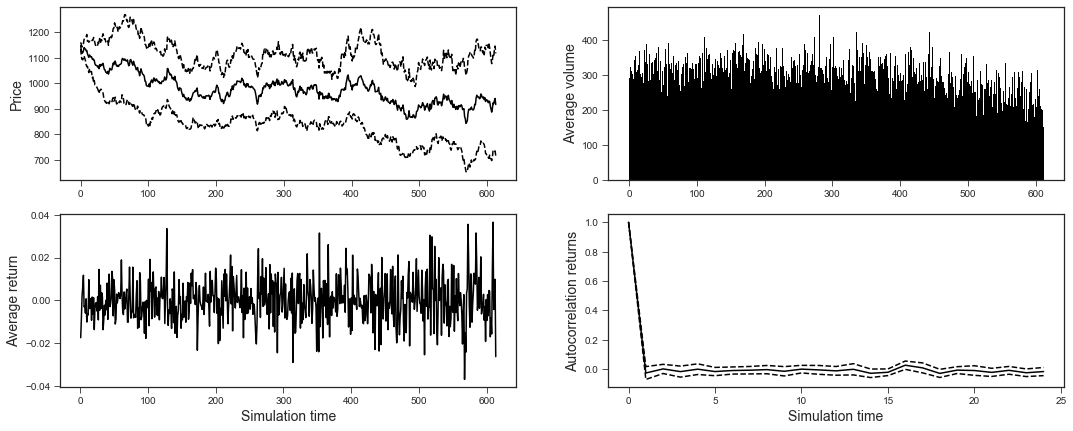

In [129]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18,7))

ax1.plot(mc_prices.index, mc_prices.mean(axis=1), 'k')
ax1.plot(mc_prices.index[:], lower_c_price, 'k--')
ax1.plot(mc_prices.index[:], upper_c_price, 'k--')
ax1.set_ylabel('Price', fontsize='14')

ax2.bar(mc_volume.index, mc_volume.mean(axis=1), width=1.0, color='black')
ax2.set_ylabel('Average volume', fontsize='14')

ax3.plot(mc_returns.index, mc_returns.mean(axis=1), 'k')
ax3.set_ylabel('Average return', fontsize='14')

ax4.plot(mc_autocorr_returns.index, mc_autocorr_returns.mean(axis=1), 'k')
ax4.plot(mc_autocorr_returns.index, lower_autocorr, 'k--')
ax4.plot(mc_autocorr_returns.index, upper_autocorr, 'k--')
ax4.set_ylabel('Autocorrelation returns', fontsize='14')


for ax in (ax3, ax4):
    ax.set_xlabel('Simulation time', fontsize='14')
    
fig.savefig('baseline_dynamics_ineq.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

Next, here are some key statistics: 

In [72]:
lower_c_vol = []
upper_c_vol = []
for row in range(len(mc_volume)):
    vol_range = mc_volume.iloc[row]
    lower, upper = confidence_interval(vol_range, np.mean(vol_range))
    lower_c_vol.append(max(lower, 0.0))
    upper_c_vol.append(upper)

In [90]:
lower_c_ret = []
upper_c_ret = []
for row in range(len(mc_returns[:-1])): # do not count the first return, because it is nan
    return_range = mc_returns.iloc[row+1]
    lower, upper = confidence_interval(return_range, np.mean(return_range))
    lower_c_ret.append(lower)
    upper_c_ret.append(upper)

In [98]:
baseline_descriptives = pd.DataFrame({
    'prices': [mc_prices.mean().mean(), np.mean(lower_c_price), np.mean(upper_c_price), mc_prices.mean().std()],
    'returns': [mc_returns.mean().mean(), np.mean(lower_c_ret), np.mean(upper_c_ret), mc_returns.mean().std()],
    'volume': [mc_volume.mean().mean(), np.mean(lower_c_vol), np.mean(upper_c_vol), mc_volume.mean().std()]
}).transpose()
baseline_descriptives.columns = ['average', 'lower band', 'upper band', 'standard deviation']

In [101]:
baseline_descriptives.round(decimals=3)

,average,lower band,upper band,standard deviation
prices,975.933,837.309,1114.557,178.678
returns,0.000,-0.020,0.020,0.001
volume,305.850,225.980,385.721,26.201


#### 2.1.2 Correlation of (log) returns, and (log) wealth.

First, I calculate the (log) wealth of all agents in time and the (log) returns they had on their portfolio in the subsequent period. 

In [53]:
portfolios = {}
long_list_portfolios = {'wealth': [], 'log_wealth': [], 'returns': [], 'log_returns':[], 'period':[], 'agent_id': []}

for seed in range(NRUNS):
    for p_idx, portf in enumerate(trdrs[seed]):
        value_over_time = []
        log_value_over_time = []
        returns_over_time = []
        log_returns_over_time = []
        periods = []
        agent = []
        
        for t in range(params["ticks"] - 1):
            v0 = portf.var.wealth[t]
            value_over_time.append(v0)
            log_value_over_time.append(np.log(v0))
            
            v1 = portf.var.wealth[t+1]
            returns_over_time.append(((v1 - v0) / v0))
            log_returns_over_time.append(np.log(v1/v0))
            
            periods.append(t)
            agent.append(str(p_idx) + '_' + str(seed))

        portfolios['value_{}_seed_{}'.format(p_idx, seed)] = value_over_time
        portfolios['log_value_{}_seed_{}'.format(p_idx, seed)] = log_value_over_time
        portfolios['return+1_{}_seed_{}'.format(p_idx, seed)] = returns_over_time
        portfolios['log_return+1_{}_seed_{}'.format(p_idx, seed)] = log_returns_over_time
        
        
        long_list_portfolios['period'] += periods
        long_list_portfolios['agent_id'] += agent#str(seed) + '_' + str(agent)
        
        long_list_portfolios['wealth'] += value_over_time
        long_list_portfolios['log_wealth'] += log_value_over_time
        long_list_portfolios['returns'] += returns_over_time
        long_list_portfolios['log_returns'] += log_returns_over_time

In [55]:
wealth_returns = pd.DataFrame(long_list_portfolios)

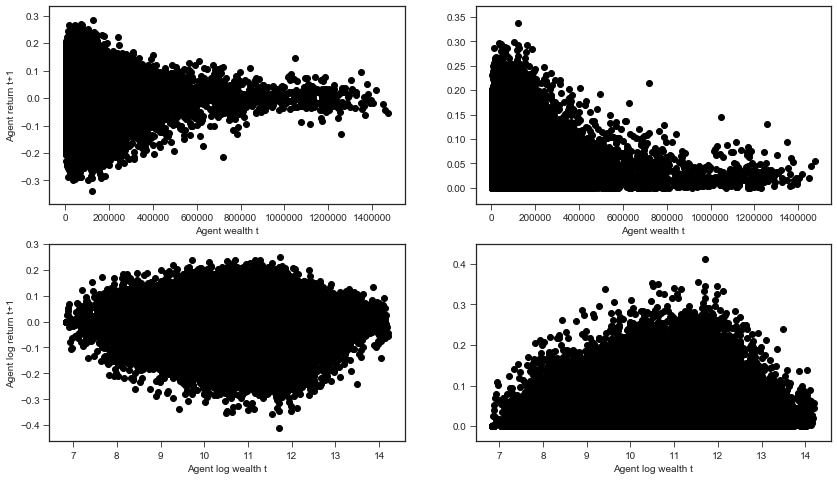

In [58]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(14,8))

ax1.scatter(wealth_returns['wealth'], wealth_returns['returns'], color='k')
ax1.set_xlabel('Agent wealth t')
ax1.set_ylabel('Agent return t+1')

ax2.scatter(wealth_returns['wealth'], wealth_returns['returns'].abs(), color='k')
ax2.set_xlabel('Agent wealth t')

ax3.scatter(wealth_returns['log_wealth'], wealth_returns['log_returns'], color='k')
ax3.set_xlabel('Agent log wealth t')
ax3.set_ylabel('Agent log return t+1')

ax4.scatter(wealth_returns['log_wealth'], wealth_returns['log_returns'].abs(), color='k')
ax4.set_xlabel('Agent log wealth t')

fig.savefig('wealth_return_scatter.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [103]:
wealth_returns.head()

,wealth,log_wealth,returns,log_returns,period,agent_id
0,121102.995327,11.704397,0.000000,0.000000,0,0_0
1,121102.995327,11.704397,0.047227,0.046146,1,0_0
2,126822.337223,11.750542,-0.210765,-0.236691,2,0_0
3,100092.604648,11.513851,0.000000,0.000000,3,0_0
4,100092.604648,11.513851,0.000000,0.000000,4,0_0


In [116]:
print('wealth / returns')
print('pearson', scipy.stats.pearsonr(wealth_returns['wealth'], wealth_returns['returns']))
print(scipy.stats.spearmanr(wealth_returns['wealth'], wealth_returns['returns']))

print('wealth / abs rets')
print('pearson', scipy.stats.pearsonr(wealth_returns['wealth'], wealth_returns['returns'].abs()))
print(scipy.stats.spearmanr(wealth_returns['wealth'], wealth_returns['returns'].abs()))

print('log wealth / log rets')
print('pearson' ,scipy.stats.pearsonr(wealth_returns['log_wealth'], wealth_returns['log_returns']))
print(scipy.stats.spearmanr(wealth_returns['log_wealth'], wealth_returns['log_returns']))
print('log wealth / log rets abs')
print('pearson', scipy.stats.pearsonr(wealth_returns['log_wealth'], wealth_returns['log_returns'].abs()))
print(scipy.stats.spearmanr(wealth_returns['log_wealth'], wealth_returns['log_returns'].abs()))

wealth / returns
pearson (-0.00307357297035326, 0.28184627030008624)
SpearmanrResult(correlation=0.003838205351085641, pvalue=0.17897706395525503)
wealth / abs rets
pearson (-0.011787944837541788, 3.6662377854578656e-05)
SpearmanrResult(correlation=0.02821656546930864, pvalue=4.998041839017565e-23)
log wealth / log rets
pearson (-0.0031725612896639274, 0.2666367729829515)
SpearmanrResult(correlation=0.003838205351085641, pvalue=0.17897706395525503)
log wealth / log rets abs
pearson (0.0037791532366235683, 0.18575736142187074)
SpearmanrResult(correlation=0.028181502512219538, pvalue=5.649570484387785e-23)


#### 2.1.3 Evolution of inequality
Gini, Palma, & individual wealth. 

In [117]:
best_traders = list(wealth_returns[wealth_returns['period'] == params['ticks']-2].sort_values(by=['wealth'], ascending=False).iloc[0:10]['agent_id'])
worst_traders = list(wealth_returns[wealth_returns['period'] == params['ticks']-2].sort_values(by=['wealth'], ascending=True).iloc[0:10]['agent_id'])

Calculate Gini and Palma ratio's of wealth over time.

In [122]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
returns = []
absolute_returns = []
market_returns = []

returns_ot = []
wealth_ot = []
log_returns_ot = []
log_wealth_ot = []

# determine the start and end wealth
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # returns
    returns.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    absolute_returns.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs[seed].tick_close_price[-1] - orbs[seed].tick_close_price[0]) / orbs[seed].tick_close_price[0] for x in range(len(wealth_start))])

    wealth_gini_over_time = []
    palma_over_time = []
    
    wealth_over_time = []
    returns_over_time = []
    log_returns_over_time = []
    log_wealth_over_time = []
    for t in range(params["ticks"]):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs[seed].tick_close_price[t])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        wealth_gini_over_time.append(gini(wealth))
        
        for a in range(len(traders)):
            wealth_over_time.append(wealth[a])
            log_wealth_over_time.append(np.log(wealth[a]))

            if t > 0:
                returns_over_time.append((wealth_over_time[t] - wealth_over_time[t-1]) / wealth_over_time[-1])
                log_returns_over_time.append(np.log(wealth_over_time[t] / wealth_over_time[t-1])) # log returns = log(return + 1)

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)
    
    returns_ot.append(returns_over_time)
    wealth_ot.append(wealth_over_time)
    log_returns_ot.append(log_returns_over_time)
    log_wealth_ot.append(log_wealth_over_time)

Calculate averages and confidence intervals. 

In [123]:
av_gini_ot = []
low_gini_ot = []
up_gini_ot = []

av_palma_ot = []
low_palma_ot = []
up_palma_ot = []

for t in range(params["ticks"]):
    t_gini = [g[t] for g in ginis_ot]
    av_gini_ot.append(np.mean(t_gini))
    low, up = confidence_interval(t_gini, np.mean(t_gini))
    low_gini_ot.append(low)
    up_gini_ot.append(up)

    t_palma = [p[t] for p in palmas_ot]
    av_palma_ot.append(np.mean(t_palma))
    low, up = confidence_interval(t_palma, np.mean(t_palma))
    low_palma_ot.append(low)
    up_palma_ot.append(up)

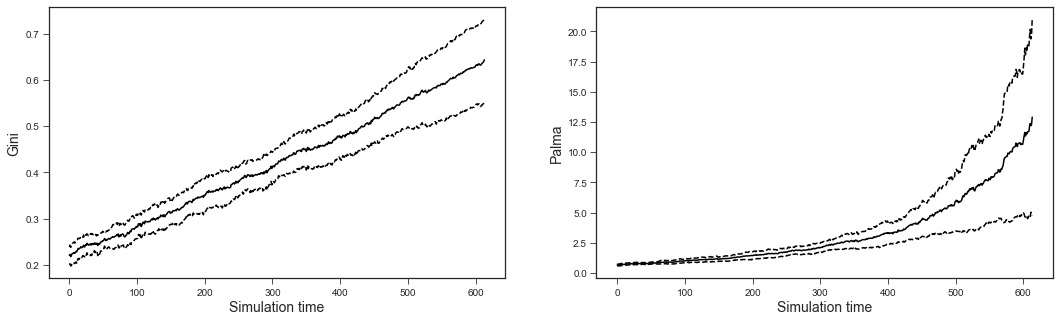

In [197]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))


ax1.plot(range(len(av_gini_ot[:])), av_gini_ot[:], 'k')
ax1.plot(range(len(low_gini_ot[:])), low_gini_ot[:], 'k--')
ax1.plot(range(len(up_gini_ot[:])), up_gini_ot[:], 'k--')
ax1.set_ylabel('Gini', fontsize='14')

ax2.plot(range(len(av_gini_ot[:])), av_palma_ot[:], 'k')
ax2.plot(range(len(low_gini_ot[:])), low_palma_ot[:], 'k--')
ax2.plot(range(len(up_gini_ot[:])), up_palma_ot[:], 'k--')
ax2.set_ylabel('Palma', fontsize='14')

    
for ax in (ax1, ax2, ax3):
    ax.set_xlabel('Simulation time', fontsize='14')
    
fig.savefig('dynamics_of_inequality.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

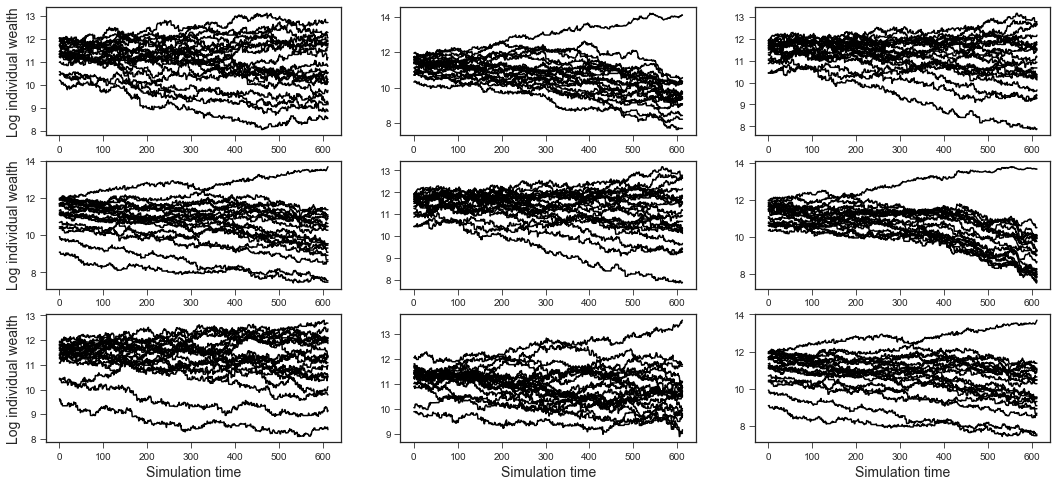

In [211]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(18,8))

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
# depict traders from a random simulation
random_simulations = np.random.randint(0, NRUNS, size=len(axes))

for idx, sim in enumerate(random_simulations):
    for tr in wealth_returns['agent_id'].unique():
        if tr[tr.find('_') + 1:] == str(sim):
            axes[idx].plot(wealth_returns[wealth_returns['agent_id'] == tr]['period'], wealth_returns[wealth_returns['agent_id'] == tr]['log_wealth'], 'k')
    if idx in [0, 3, 6]:
        axes[idx].set_ylabel('Log individual wealth', fontsize='14')

for x in [ax7, ax8, ax9]:
    x.set_xlabel('Simulation time', fontsize='14')
    

fig.savefig('inequality_paths.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# 3 Experiment

# 4 Use global sensitivity analysis to calcuate confidence intervals